In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys
FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

07-Feb-21 19:44:28 Loading position info...
07-Feb-21 19:44:59 Loading multiunit...
07-Feb-21 19:45:25 Loading spikes...
07-Feb-21 19:46:57 Finding ripple times...


In [5]:
continuous_transition_types = [['random_walk_direction2', 'random_walk',            'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['random_walk',            'random_walk_direction1', 'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk_direction1', 'random_walk',            'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk',            'random_walk_direction2', 'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ]
encoding_group_to_state = ['Inbound', 'Inbound', 'Inbound', 'Outbound', 'Outbound', 'Outbound']

# use identity instead of random walk at transition?
# exclude diagonal of random walk?


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

notnull = pd.notnull(data["position_info"].task)

In [6]:
from replay_trajectory_classification import ClusterlessClassifier

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

state_names = ['Inbound-Forward', 'Inbound-Reverse', 'Inbound-Fragmented',
               'Outbound-Forward', 'Outbound-Reverse', 'Outbound-Fragmented']
cv = KFold()

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    cv_classifier = ClusterlessClassifier(**classifier_parameters)
    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=notnull.iloc[train],
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
        encoding_group_labels=inbound_outbound_labels[train],
        encoding_group_to_state=encoding_group_to_state
    )

07-Feb-21 19:50:14 Fitting Fold #1...
07-Feb-21 19:50:15 Fitting initial conditions...
07-Feb-21 19:50:15 Fitting state transition...
07-Feb-21 19:50:23 Fitting multiunits...
07-Feb-21 19:50:25 Fitting Fold #2...
07-Feb-21 19:50:25 Fitting initial conditions...
07-Feb-21 19:50:25 Fitting state transition...
07-Feb-21 19:50:34 Fitting multiunits...
07-Feb-21 19:50:35 Fitting Fold #3...
07-Feb-21 19:50:35 Fitting initial conditions...
07-Feb-21 19:50:35 Fitting state transition...
07-Feb-21 19:50:44 Fitting multiunits...
07-Feb-21 19:50:45 Fitting Fold #4...
07-Feb-21 19:50:46 Fitting initial conditions...
07-Feb-21 19:50:46 Fitting state transition...
07-Feb-21 19:50:56 Fitting multiunits...
07-Feb-21 19:50:57 Fitting Fold #5...
07-Feb-21 19:50:57 Fitting initial conditions...
07-Feb-21 19:50:57 Fitting state transition...
07-Feb-21 19:51:06 Fitting multiunits...


In [12]:
cv_classifier_clusterless_results = xr.open_dataset(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_forward_reverse_nose_no_vel_results.nc")
cv_classifier_clusterless_results

<xarray.Dataset>
Dimensions:            (position: 201, state: 6, time: 448561)
Coordinates:
  * time               (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position           (position) float64 0.9993 2.998 4.997 ... 420.7 422.7
  * state              (state) object 'Inbound-Forward' ... 'Outbound-Fragmen...
Data variables:
    likelihood         (time, state, position) float64 ...
    causal_posterior   (time, state, position) float64 ...
    acausal_posterior  (time, state, position) float64 ...

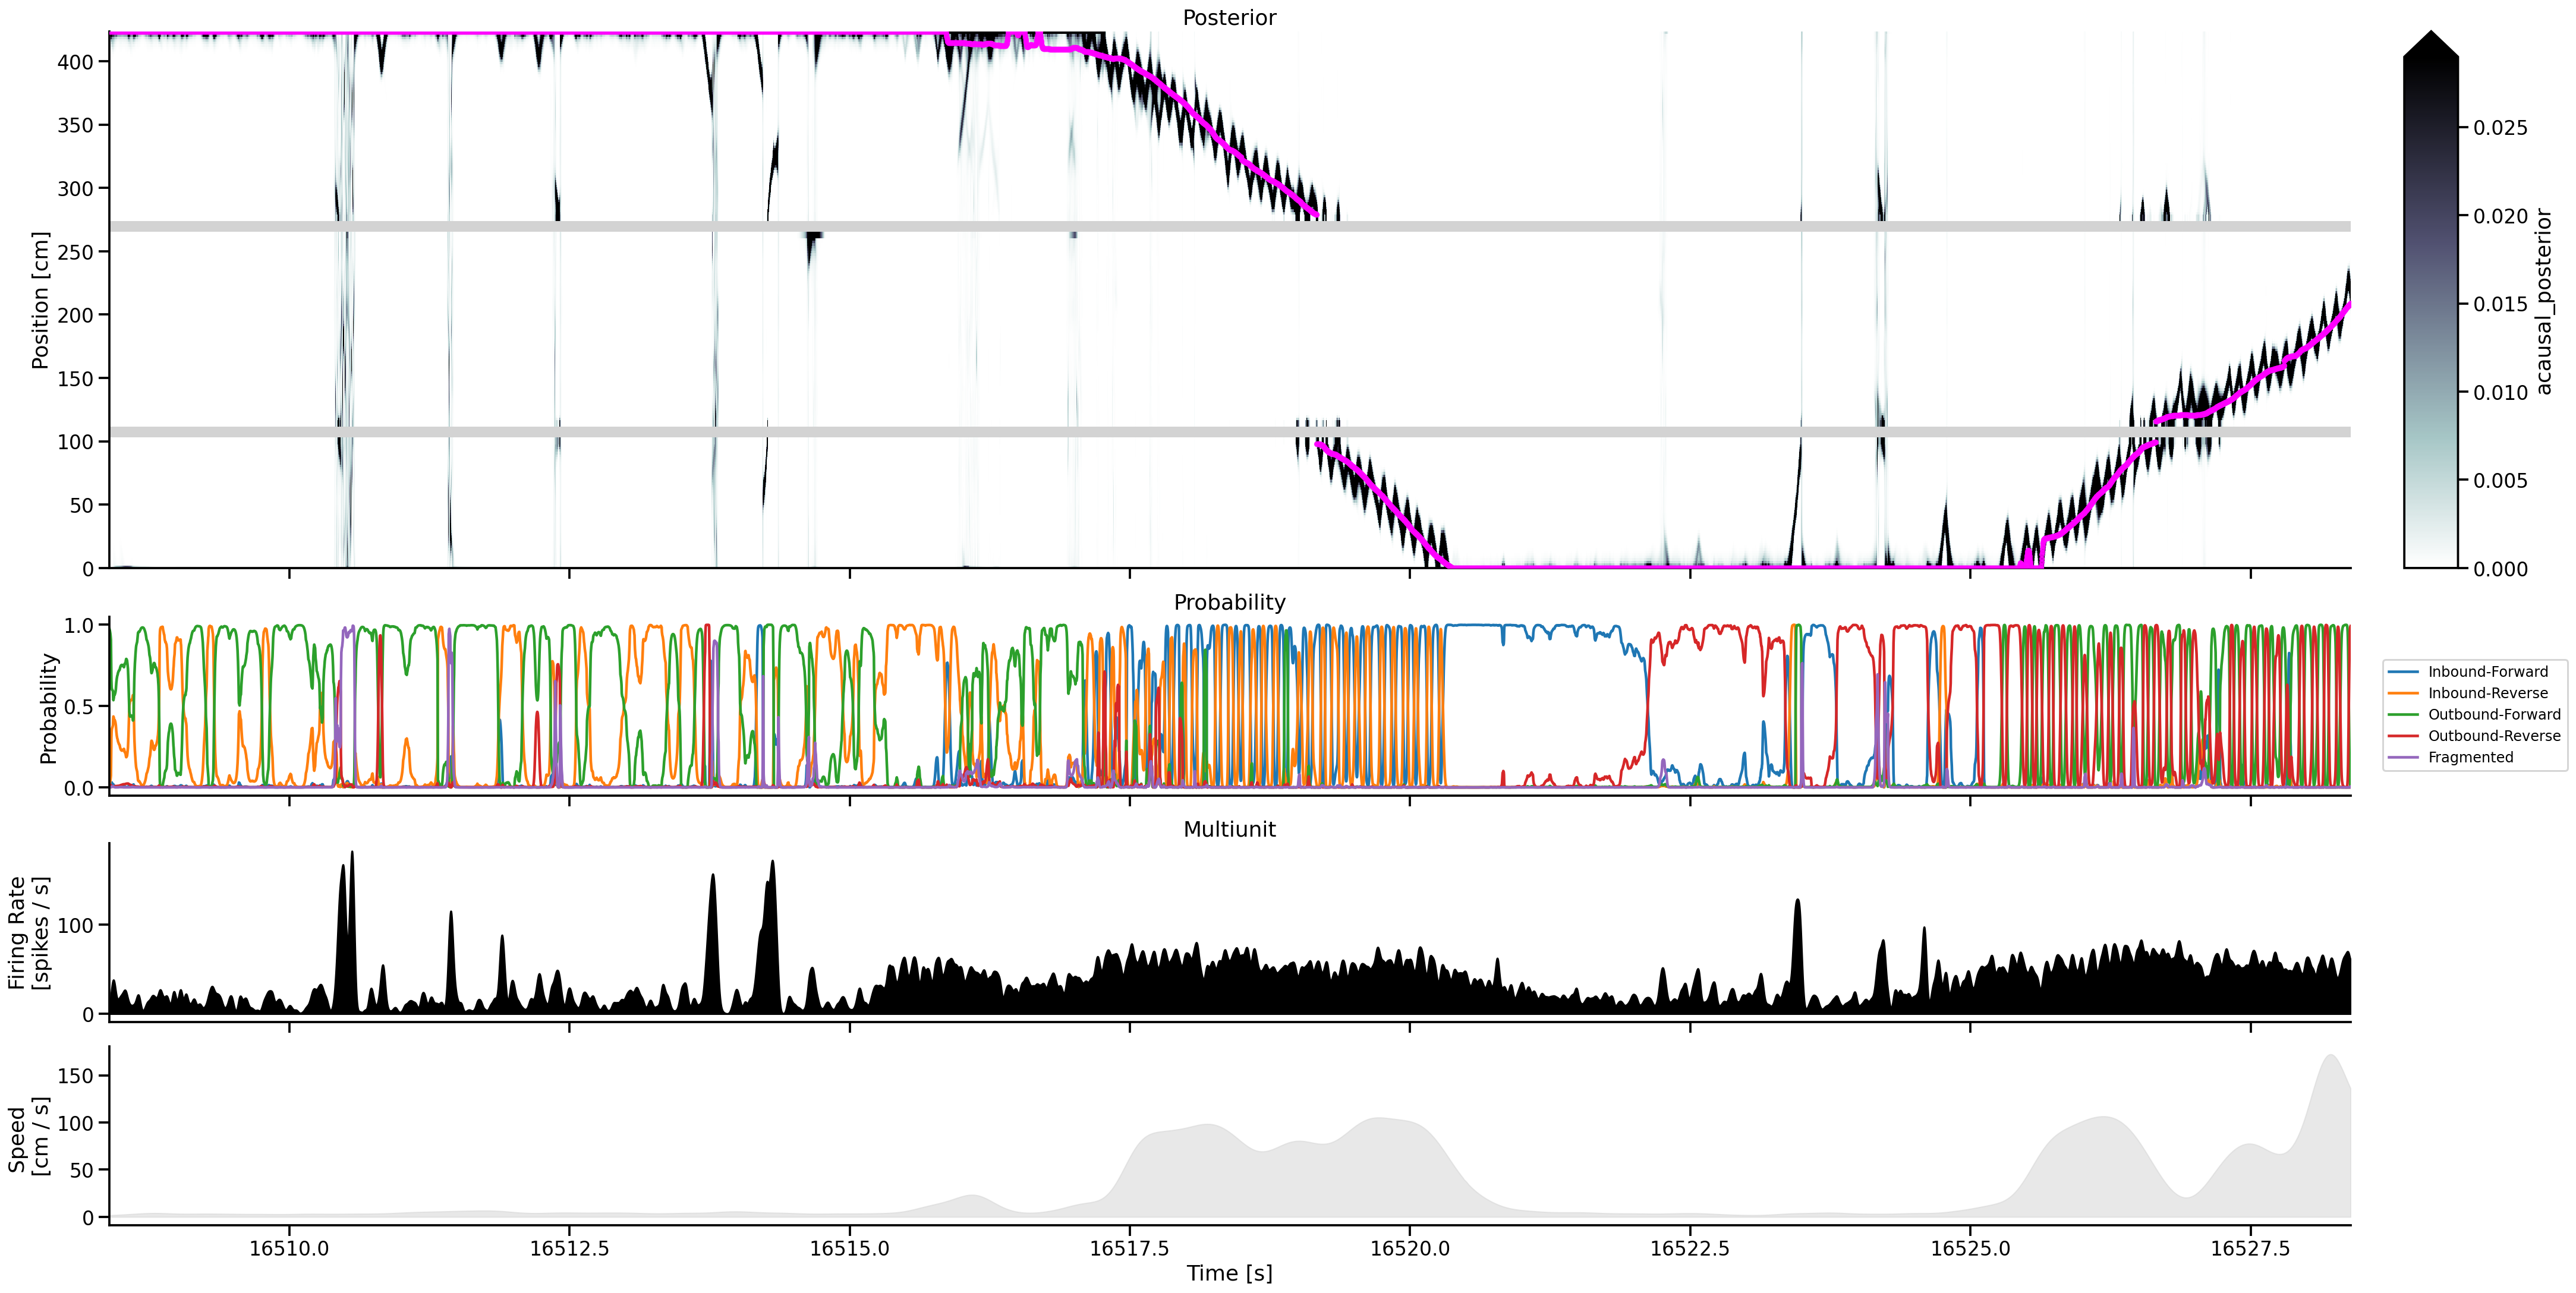

In [13]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(70_000, 80_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

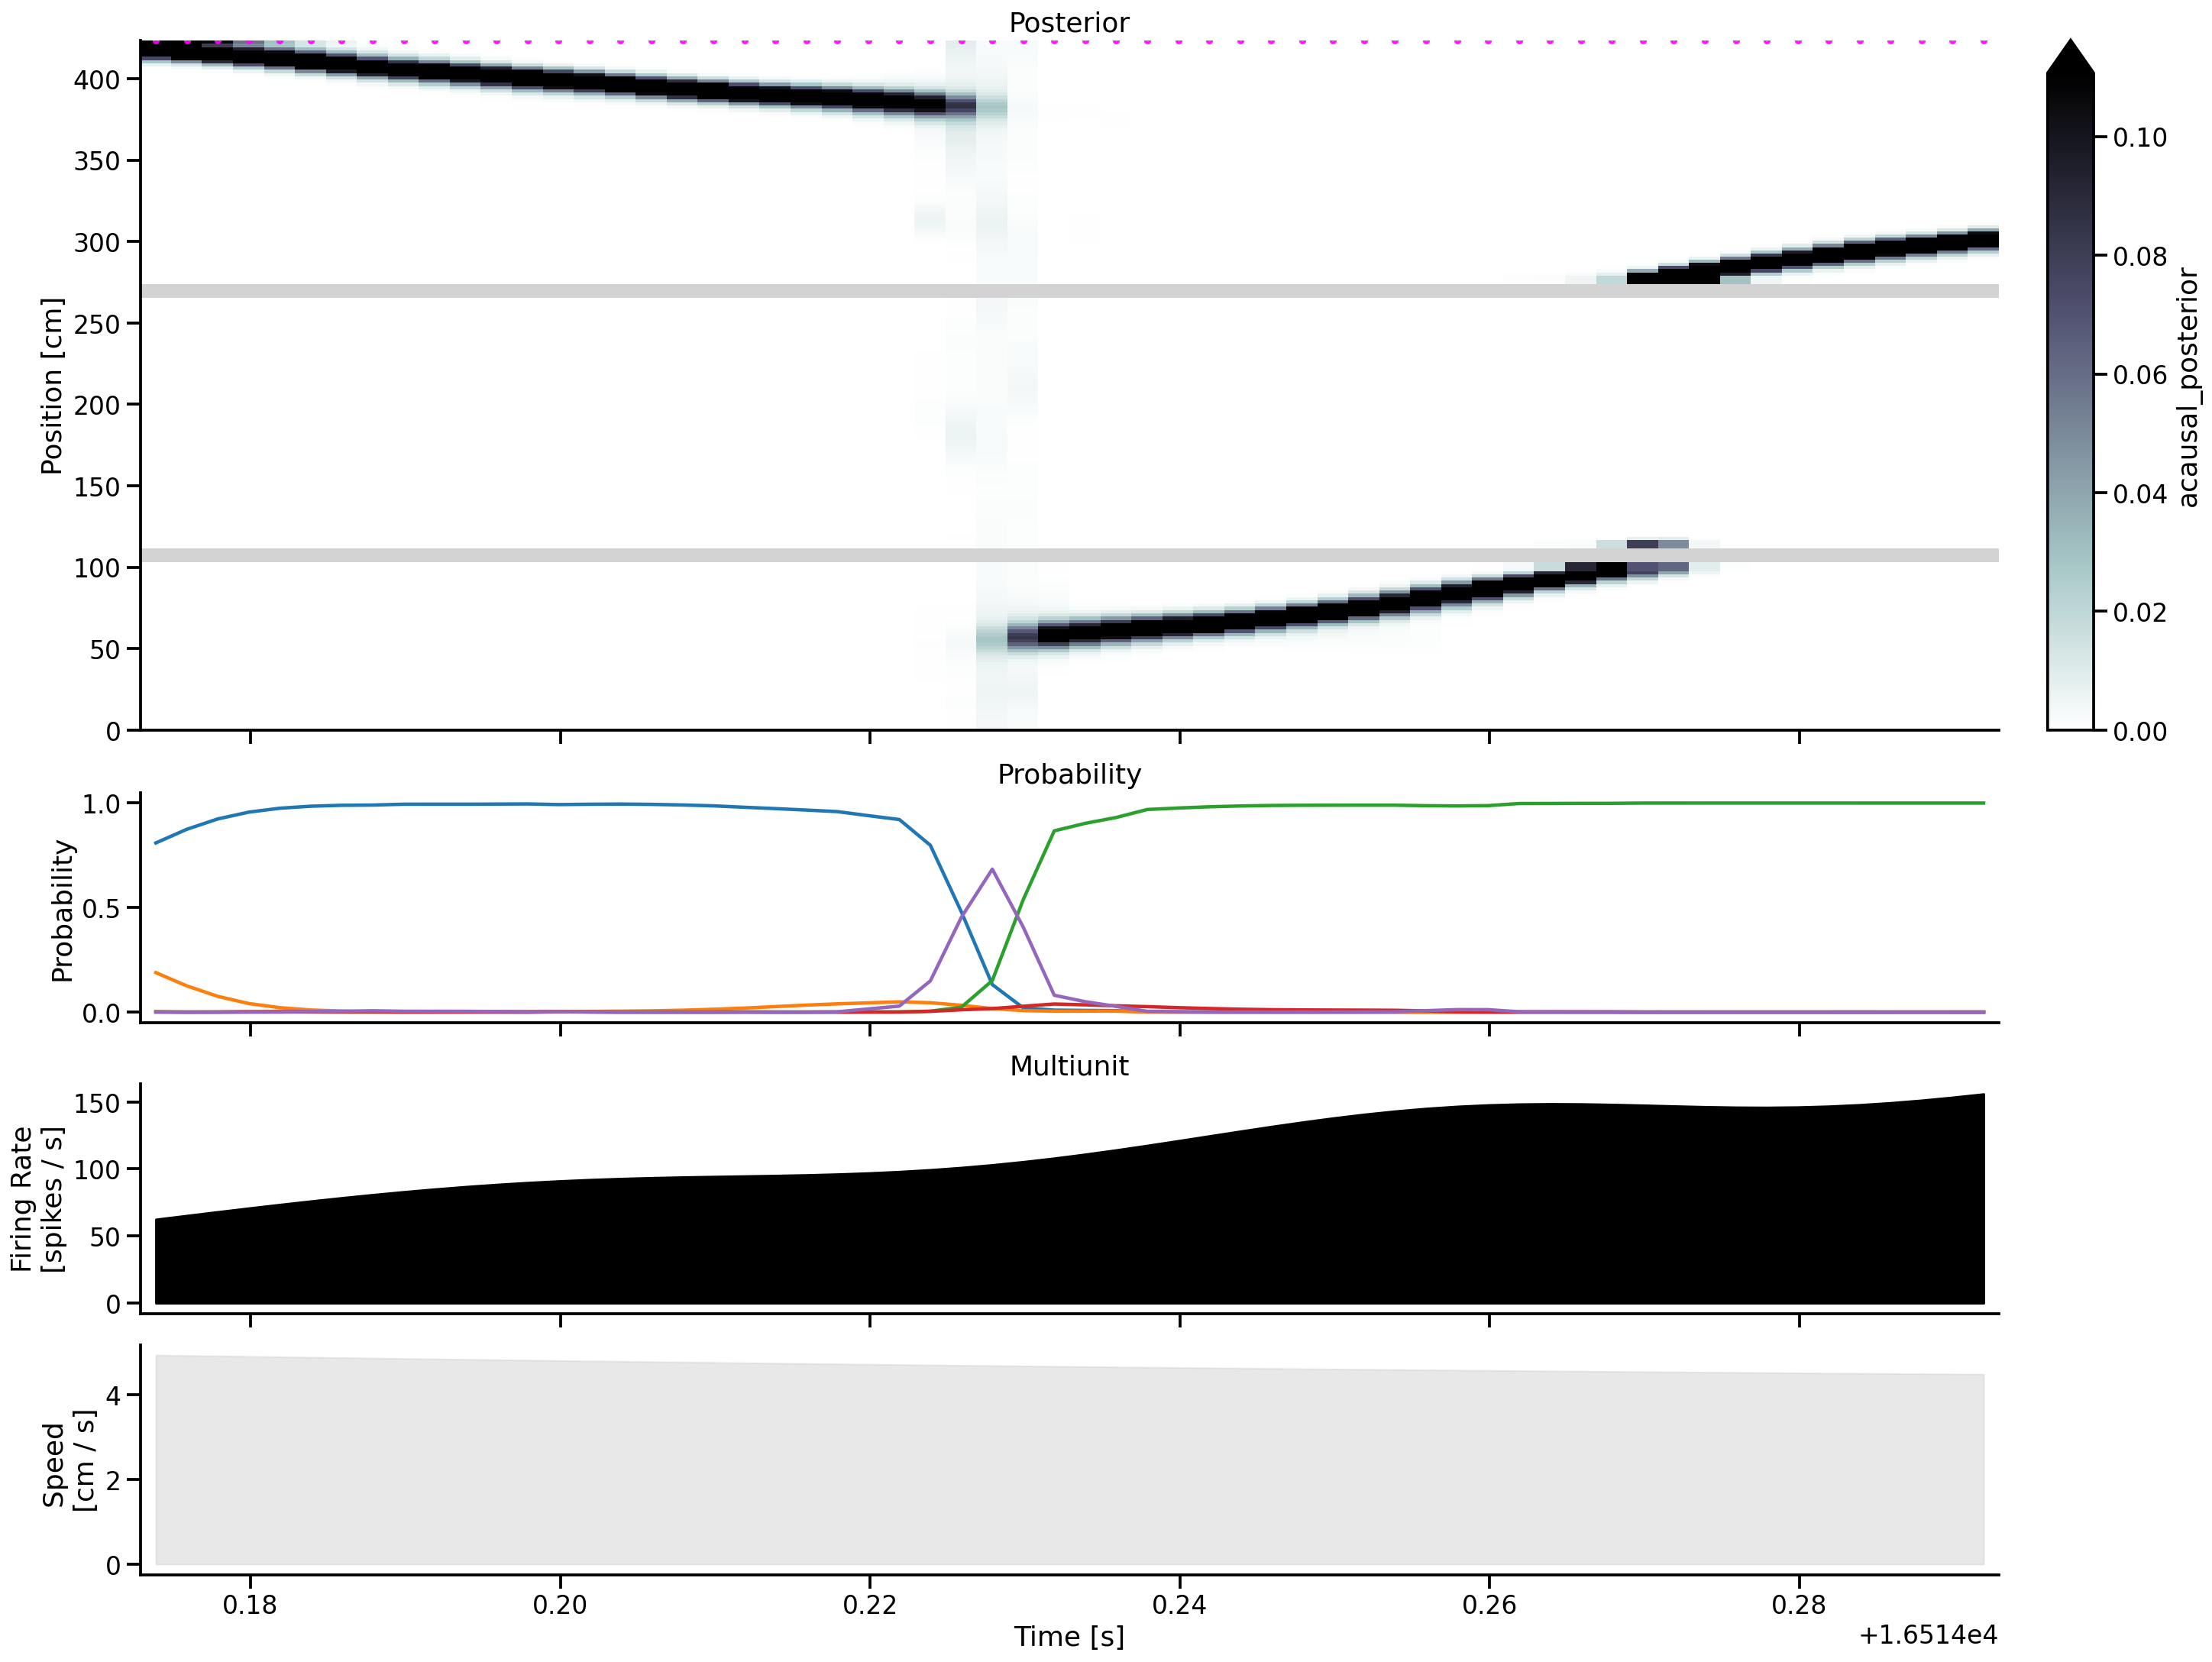

In [43]:
time_slice = cv_classifier_clusterless_results.time[slice(72_890, 72_950)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=False,
)

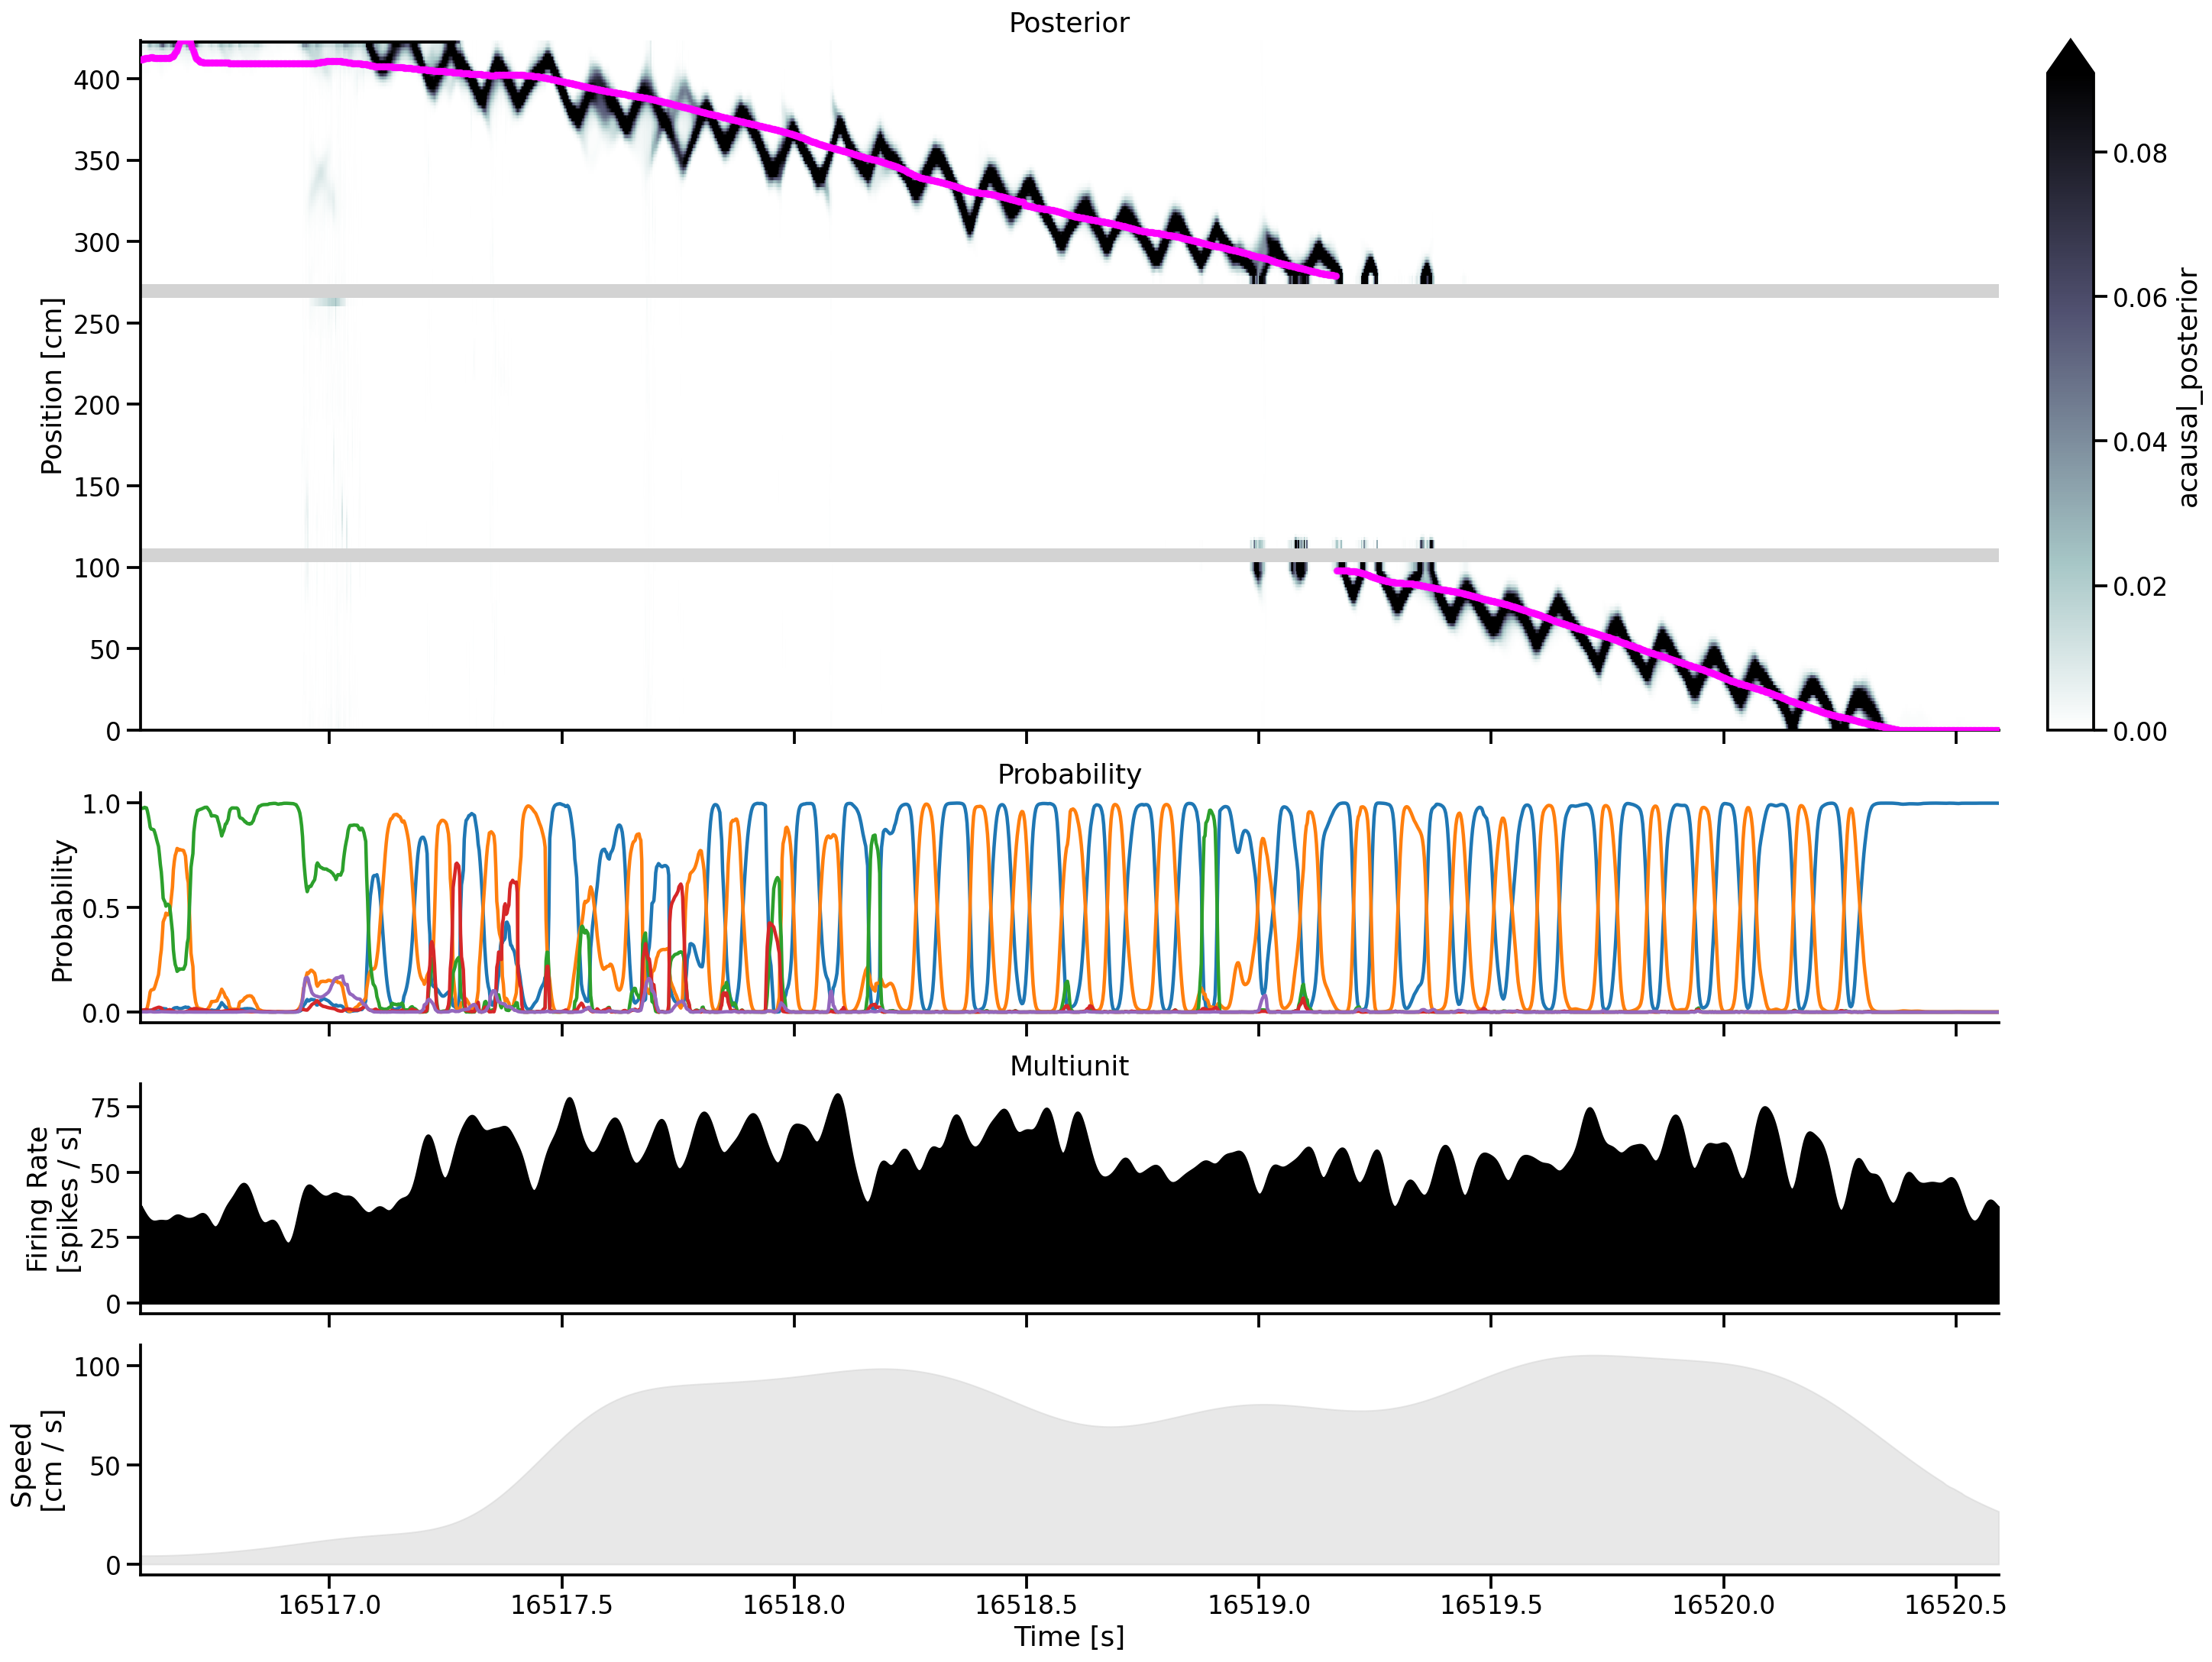

In [45]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(74_100, 76_100)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=False,
)

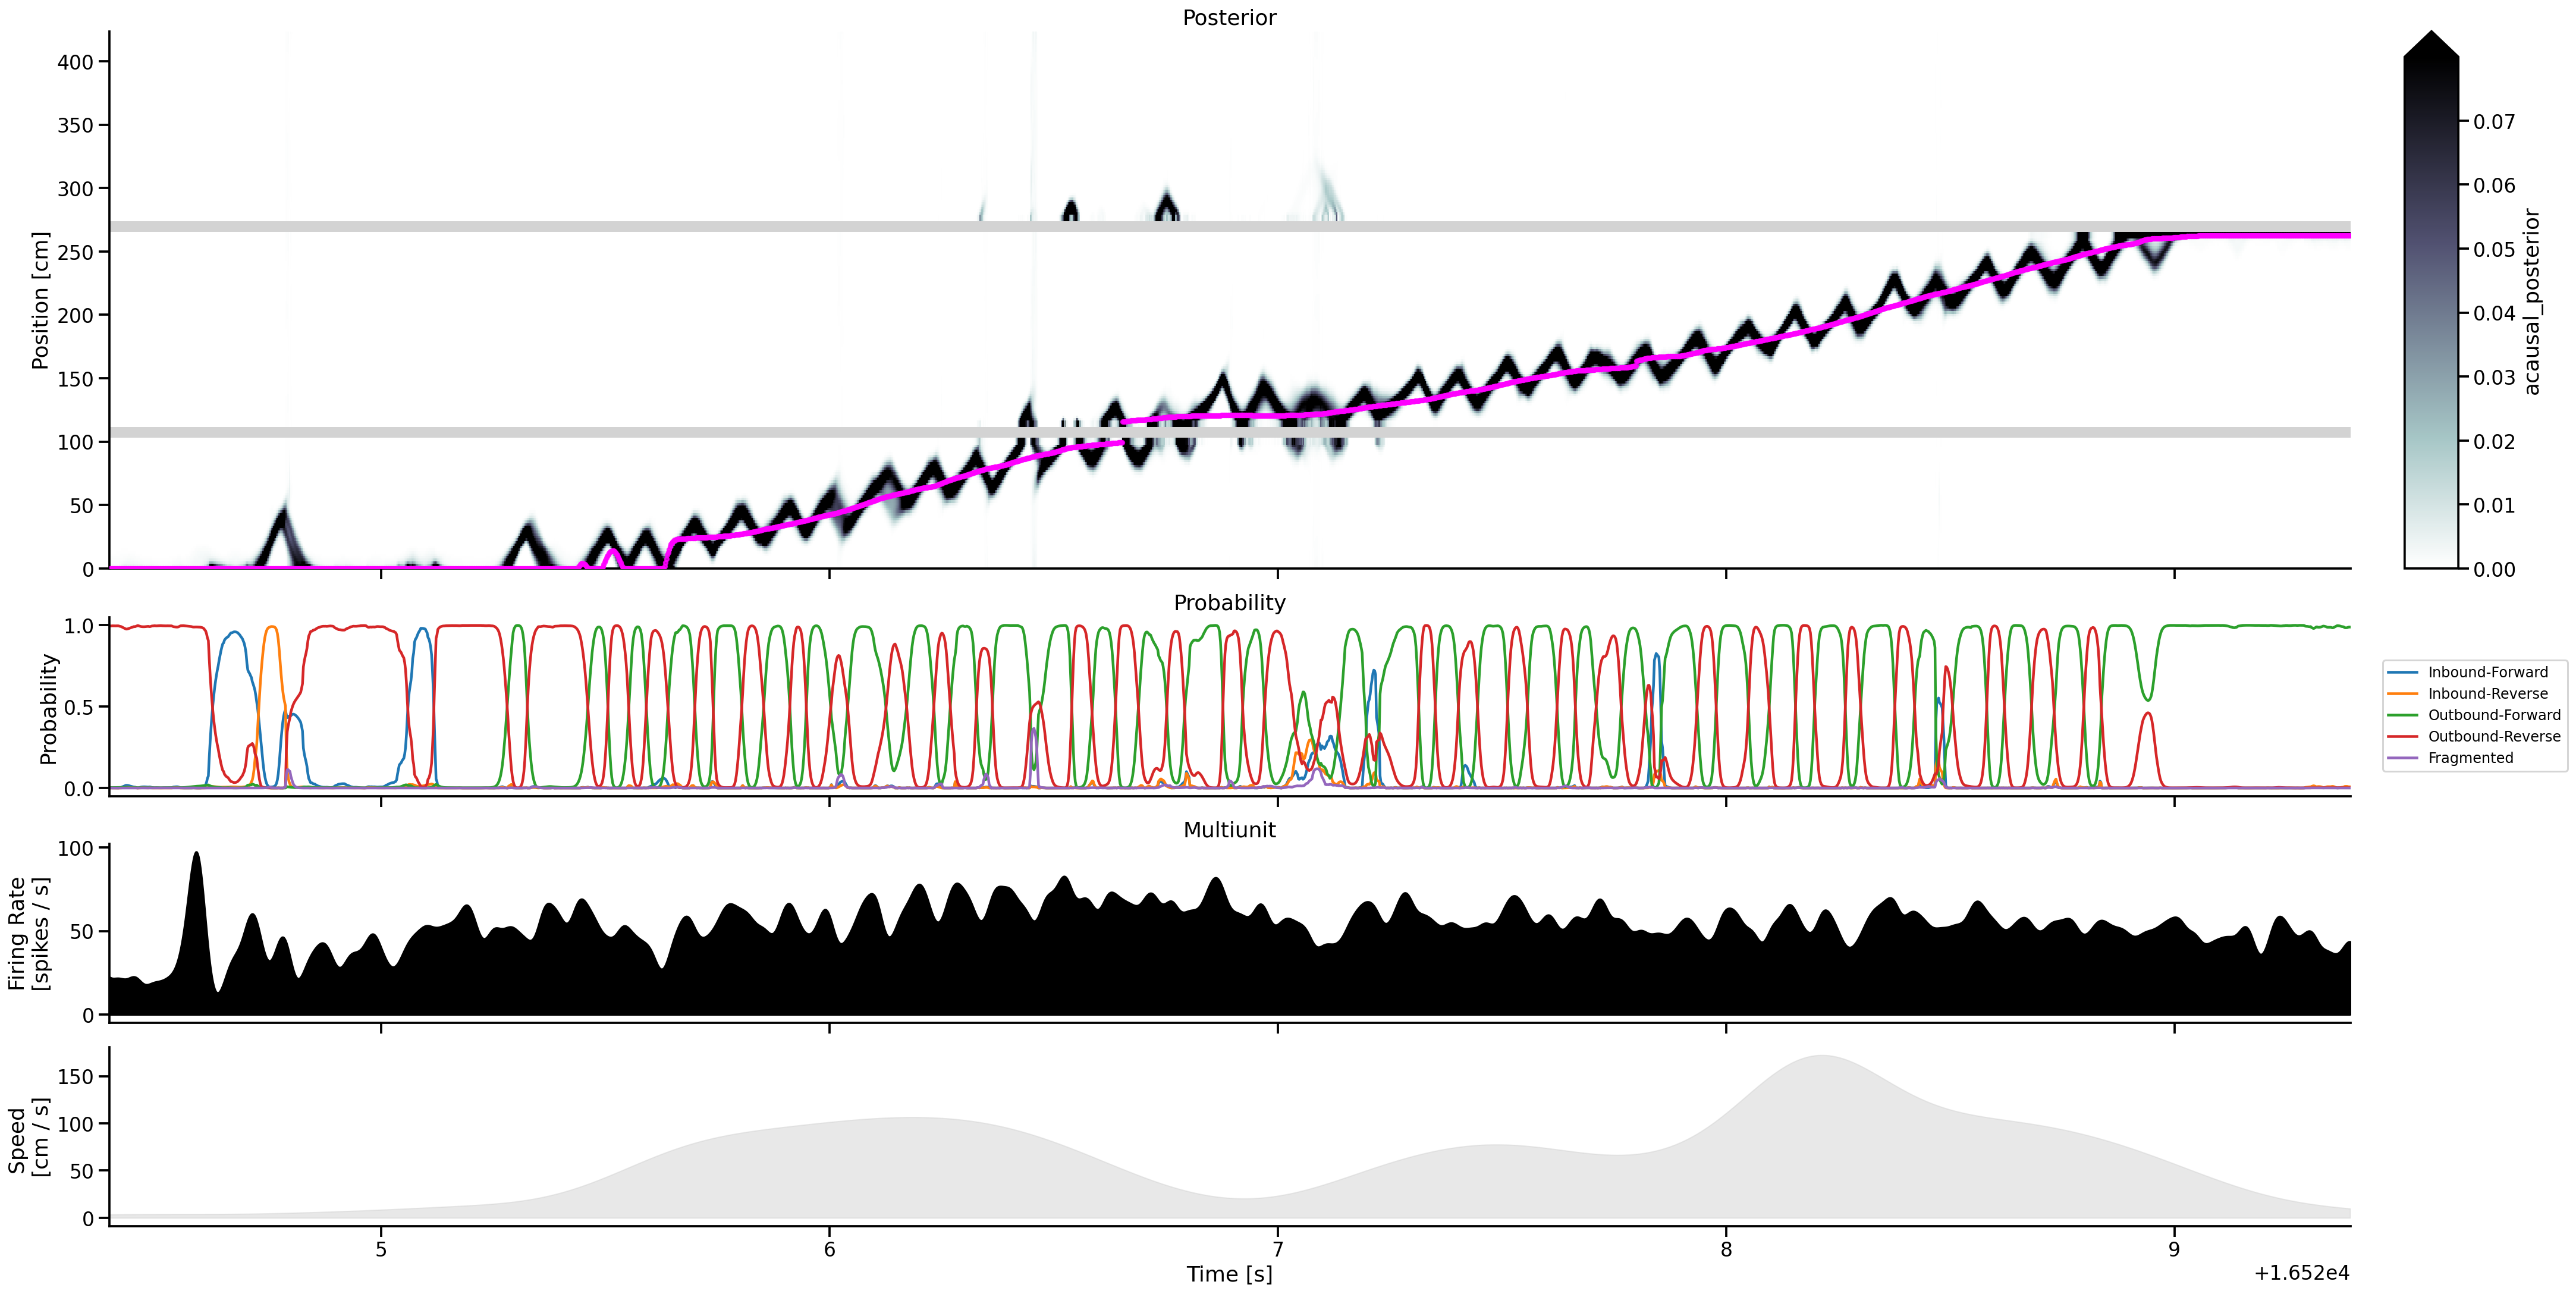

In [44]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(78_000, 80_500)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)